In [1]:
%matplotlib inline


DC1dBlock
---------

This tutorial shows how an built-in forward operator is used for inversion.
A DC 1D (VES) modelling is used to generate data, noisify and invert them.



We import numpy, matplotlib and the 1D plotting function



In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pygimli as pg
from pygimli.mplviewer import drawModel1D

some definitions before (model, data and error)



In [3]:
nlay = 4  # number of layers
lam = 200.  # (initial) regularization parameter
errPerc = 10.  # relative error of 3 percent
ab2 = np.logspace(-1, 2, 50)  # AB/2 distance (current electrodes)
mn2 = ab2 / 3.  # MN/2 distance (potential electrodes)

In [5]:
ab2,mn2

(array([  0.1       ,   0.11513954,   0.13257114,   0.1526418 ,
          0.17575106,   0.20235896,   0.23299518,   0.26826958,
          0.30888436,   0.35564803,   0.40949151,   0.47148664,
          0.54286754,   0.62505519,   0.71968567,   0.82864277,
          0.95409548,   1.09854114,   1.26485522,   1.45634848,
          1.67683294,   1.93069773,   2.22299648,   2.55954792,
          2.9470517 ,   3.39322177,   3.90693994,   4.49843267,
          5.17947468,   5.96362332,   6.86648845,   7.90604321,
          9.10298178,  10.48113134,  12.06792641,  13.89495494,
         15.9985872 ,  18.42069969,  21.20950888,  24.42053095,
         28.11768698,  32.37457543,  37.2759372 ,  42.9193426 ,
         49.41713361,  56.89866029,  65.51285569,  75.43120063,
         86.85113738, 100.        ]),
 array([3.33333333e-02, 3.83798466e-02, 4.41903789e-02, 5.08805989e-02,
        5.85836875e-02, 6.74529883e-02, 7.76650604e-02, 8.94231932e-02,
        1.02961453e-01, 1.18549344e-01, 1.36497169

initialize the forward modelling operator



In [6]:
f = pg.DC1dModelling(nlay, ab2, mn2)
f

other ways are by specifying a Data Container or am/an/bm/bn distances



In [19]:
synres = [100., 500., 20., 800.]  # synthetic resistivity
synthk = [0.5, 3.5, 6.]  # synthetic thickness (nlay-th layer is infinite)

the forward operator can be called by f.response(model) or simply f(model)



In [20]:
rhoa = f(synthk+synres)
rhoa = rhoa * (pg.randn(len(rhoa)) * errPerc / 100. + 1.)
rhoa

In [33]:
rhoa[-1]

248.37689909272493

In [48]:
transThk = pg.RTransLog()  # log-transform ensures thk>0
transRho = pg.RTransLogLU(1, 1000)  # lower and upper bound
transRhoa = pg.RTransLog()  # log transformation for data

In [49]:
mlay = 5  # number of layers
lam = 200.  # (initial) regularization parameter
mab2=[1,	2,	3,	4,	5,	5,	6,	8,	10,	15,	20,	25,	25,	30,	35,	40,	50,	50,	60,	70,	80,	90,	100,	100,	110,	120,	130,	140,	160,	160,	180,	200,	220,	240,	260,	280,	300]
mmn2=[0.4,	0.4,	0.4,	0.4,	0.4,	2,	2,	2,	2,	2,	2,	2,	5,	5,	5,	5,	5,	10,	10,	10,	10,	10,	10,	20,	20,	20,	20,	20,	20,	30,	30,	30,	30,	30,	30,	30,	30]

mrhoa=[20.19,	14.45,	14.26,	17.16,	17.55,	18.13,	20,	26.75,	30.07,	41.12,	59.69,	66.79,	73.29,	81.6,	110.78,	139.96,	179.52,	194.43,	229.69,	238.14,	305.63,	317.77,	354.38,	378.31,	406.87,	434.11,	490.9,	550.13,	638.96,	670.88,	717.1,	793.94,	825.3,	884.26,	925.02,	981.51,	1021.18]


In [50]:
# mab2,mrhoa
mf = pg.DC1dModelling(mlay, mab2, mmn2)
mf

In [51]:
mf.region(0).setTransModel(transThk)  # 0=thickness
mf.region(1).setTransModel(transRho)  # 1=resistivity

In [52]:
mparaDepth = max(mab2) / 3.  # rule-of-thumb for Wenner/Schlumberger
mf.region(0).setStartValue(mparaDepth / mlay / 2)
mf.region(1).setStartValue(np.median(mrhoa))

In [53]:
minv = pg.RInversion(mrhoa, mf, transRhoa, True)  # data vector, fop, verbose
# could also be set by inv.setTransData(transRhoa)

In [54]:
minv.setRelativeError(errPerc / 100.0)  # alternative: setAbsoluteError in Ohmm
minv.setLambda(lam)  # (initial) regularization parameter
minv.setMarquardtScheme(0.9)  # decrease lambda by factor 0.9
model = mf.createStartVector()  # creates from region start value
model[nlay] *= 1.5  # change default model by changing 2nd layer resistivity
minv.setModel(model)  #

In [55]:
model = minv.run()  # result is a pg.RVector, but compatible to numpy array
res, thk = model[mlay-1:mlay*2-1], model[0:mlay-1]
print('rrms={:.2f}%, chi^2={:.3f}'.format(minv.relrms(), minv.chi2()))

rrms=30.17%, chi^2=10.037


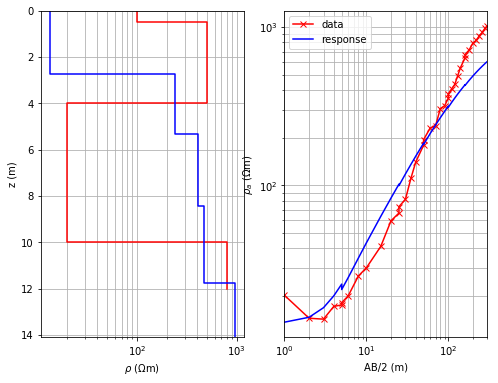

In [58]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 6))  # two-column figure
drawModel1D(ax[0], synthk, synres, plot='semilogx', color='r')
drawModel1D(ax[0], thk, res, color='b')
ax[0].grid(True, which='both')
ax[0].set_ylabel('z (m)')
ax[0].set_xlabel(r'$\rho$ ($\Omega$m)')
ax[1].loglog( mab2, mrhoa,'rx-', label='data')  # sounding curve
ax[1].loglog( mab2, minv.response(),'b-', label='response')
ax[1].set_xlim(( min(mab2),max(mab2)))  # downwards according to penetration
ax[1].grid(True, which='both')
ax[1].set_ylabel(r'$\rho_a$ ($\Omega$m)')
ax[1].set_xlabel('AB/2 (m)')
ax[1].legend(loc='best')
plt.show()

create some transformations used for inversion



set model transformation for thickness and resistivity



In [22]:
f.region(0).setTransModel(transThk)  # 0=thickness
f.region(1).setTransModel(transRho)  # 1=resistivity

generate start model values from median app. resistivity & spread



In [23]:
paraDepth = max(ab2) / 3.  # rule-of-thumb for Wenner/Schlumberger
f.region(0).setStartValue(paraDepth / nlay / 2)
f.region(1).setStartValue(np.median(rhoa))

set up inversion



In [24]:
inv = pg.RInversion(rhoa, f, transRhoa, True)  # data vector, fop, verbose
# could also be set by inv.setTransData(transRhoa)

set error model, regularization strength and Marquardt scheme



In [25]:
inv.setRelativeError(errPerc / 100.0)  # alternative: setAbsoluteError in Ohmm
inv.setLambda(lam)  # (initial) regularization parameter
inv.setMarquardtScheme(0.9)  # decrease lambda by factor 0.9
model = f.createStartVector()  # creates from region start value
model[nlay] *= 1.5  # change default model by changing 2nd layer resistivity
inv.setModel(model)  #

run actual inversion and extract resistivity and thickness



In [26]:
model = inv.run()  # result is a pg.RVector, but compatible to numpy array
res, thk = model[nlay-1:nlay*2-1], model[0:nlay-1]
print('rrms={:.2f}%, chi^2={:.3f}'.format(inv.relrms(), inv.chi2()))

rrms=11.18%, chi^2=1.247


show estimated&synthetic models and data with model response in 2 subplots



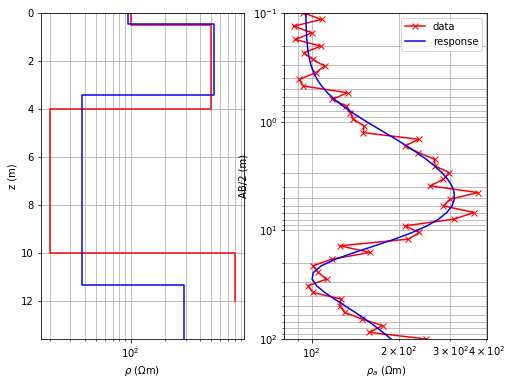

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 6))  # two-column figure
drawModel1D(ax[0], synthk, synres, plot='semilogx', color='r')
drawModel1D(ax[0], thk, res, color='b')
ax[0].grid(True, which='both')
ax[0].set_ylabel('z (m)')
ax[0].set_xlabel(r'$\rho$ ($\Omega$m)')
ax[1].loglog(rhoa, ab2, 'rx-', label='data')  # sounding curve
ax[1].loglog(inv.response(), ab2, 'b-', label='response')
ax[1].set_ylim((max(ab2), min(ab2)))  # downwards according to penetration
ax[1].grid(True, which='both')
ax[1].set_xlabel(r'$\rho_a$ ($\Omega$m)')
ax[1].set_ylabel('AB/2 (m)')
ax[1].legend(loc='best')
plt.show()